# Dynamic Regression models

- We represent our model as 
$$
y_t = \beta_0 + \sum_{i=1}^k\beta_i x_{i,t} + \eta_t
$$

where $\eta_t$ is an ARIMA model instead of a white noise.
- We minimize the epsilon error
- An important consideration when estimating a regression with ARMA errors is that all of the variables in the model must first be stationary. 
    - y_t is stationary
    - all of X

In [485]:
import warnings

# np and pandas
import numpy as np
import pandas as pd

from tsdata.raw import available_data, load_data
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import Holt
from statsmodels.tsa.seasonal import STL

# sktime functionaliy
from sktime.forecasting.compose import make_reduction

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import (mean_absolute_error, mean_squared_error,
                                                    mean_absolute_percentage_error, mean_absolute_scaled_error)


from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, PolynomialFeatures
from sktime.datasets import load_macroeconomic
from sktime.forecasting.compose import ForecastingPipeline, TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.impute import Imputer

# from sklearn.compose import ColumnTransformer
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sktime.transformations.panel.reduce import Tabularizer
from tsdata.raw import available_data, load_data
from sklearn.preprocessing import FunctionTransformer



# set style of plots
plt.style.use('Solarize_Light2')

### ARIMA with X variables

In [ ]:
# Exogeneous ARIMA
# differencing is done on all variables, not only y
# Whether differencing is required is determined by applying a KPSS test

In [7]:
# Example: US Personal Consumption and Income
us_change_df = load_data("us_change").assign(
    Date=lambda df: pd.to_datetime(df.Quarter.str.replace(" ", "-"))
).drop("Quarter", axis=1).set_index("Date")

us_change_df.head(3)

,Consumption,Income,Production,Savings,Unemployment
Date,,,,,
1970-01-01,0.618566,1.044801,-2.452486,5.299014,0.9
1970-04-01,0.451984,1.225647,-0.551459,7.789894,0.5
1970-07-01,0.872872,1.585154,-0.358652,7.403984,0.5


In [ ]:
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=fh)

y = us_change_df.Consumption

In [ ]:
forecaster1 = AutoARIMA(start_p=0, start_q=0, max_p=1, max_q=2, d=0)
# forecaster3 = make_reduction(LinearRegression())

forecaster1.fit(us_change_df.Consumption, us_change_df[['Income']])

<AxesSubplot:>

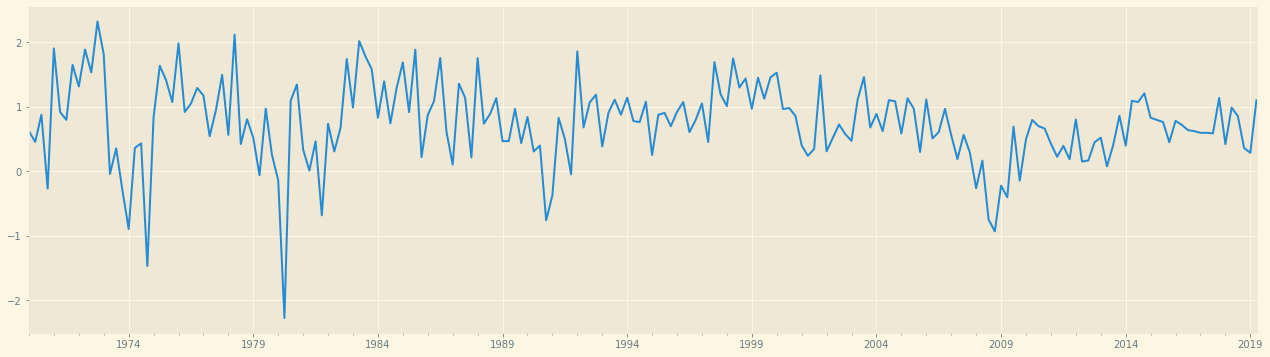

In [22]:
us_change_df.Consumption.plot(figsize=(22, 6))

In [20]:
print(forecaster1._get_fitted_params())
print(forecaster1._get_fitted_param_names())
forecaster1._forecaster.summary()

[ 0.17424443  0.19762276  0.70710279 -0.61731434  0.20662407  0.30347838]
['intercept', 'Income', 'ar.L1', 'ma.L1', 'ma.L2', 'sigma2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -163.036
Date:                Tue, 22 Mar 2022   AIC                            338.072
Time:                        13:19:53   BIC                            357.802
Sample:                    01-01-1970   HQIC                           346.058
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1742      0.062      2.788      0.005       0.052       0.297
Income         0.1976      0.034      5.855      0.000       0.131       0.264
ar.L1          0.7071      0.106      6.659      0.000       0.499       0.915
ma.L1         -0.6173      0.113     -5.470      0.000      -0.839      -0.396
ma.L2          0.2066      0.065      3.174      0.002       0.079       0.334
sigma2         0.3035      0.022     13.525      0.000       0.260       0.347
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                45.83
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Example: Forecasting electricity demand

Daily electricity demand can be modelled as a function of temperature. As can be observed on an electricity bill, more electricity is used on cold days due to heating and hot days due to air conditioning.


In [595]:
import holidays

# Select country
victoria_holidays = holidays.AUS(subdiv='VIC')

vic_elec_df = (load_data("vic_elec")
 .assign(Time=lambda df: pd.to_datetime(df.Time))
)

victoria_electricity_2014 = vic_elec_df[
    vic_elec_df.Time.dt.year == 2014
]

victoria_electricity_2014 = (victoria_electricity_2014
 .groupby([victoria_electricity_2014.Time.dt.date])
# .groupby('Time')
 .agg({'Demand': 'sum', 'Temperature': 'max'})
 .assign(
     Demand=lambda df: df.Demand / 1e3,
     Time=lambda df: pd.to_datetime(df.index)
 )
 .assign(
     # assign whether its weekend or holiday
     day_type=lambda df: df.Time.apply(
        #  NOTE: I can also use enum for that, especially in production
         lambda time: 'Holiday' if time in victoria_holidays else
                      'Weekend' if time.weekday() > 4 else
                      'Weekday'
     )
 )
 # turn the day type to categorical
 .assign(day_type=lambda df: pd.Categorical(df.day_type))
 .set_index('Time')
)

start_date = min(victoria_electricity_2014.index)
end_date = max(victoria_electricity_2014.index)
electricity_index = pd.date_range(start=start_date, end=end_date, freq='D')

victoria_electricity_2014 = victoria_electricity_2014.reindex(electricity_index)

Text(0.5, 0, 'Max Daily Temperature')

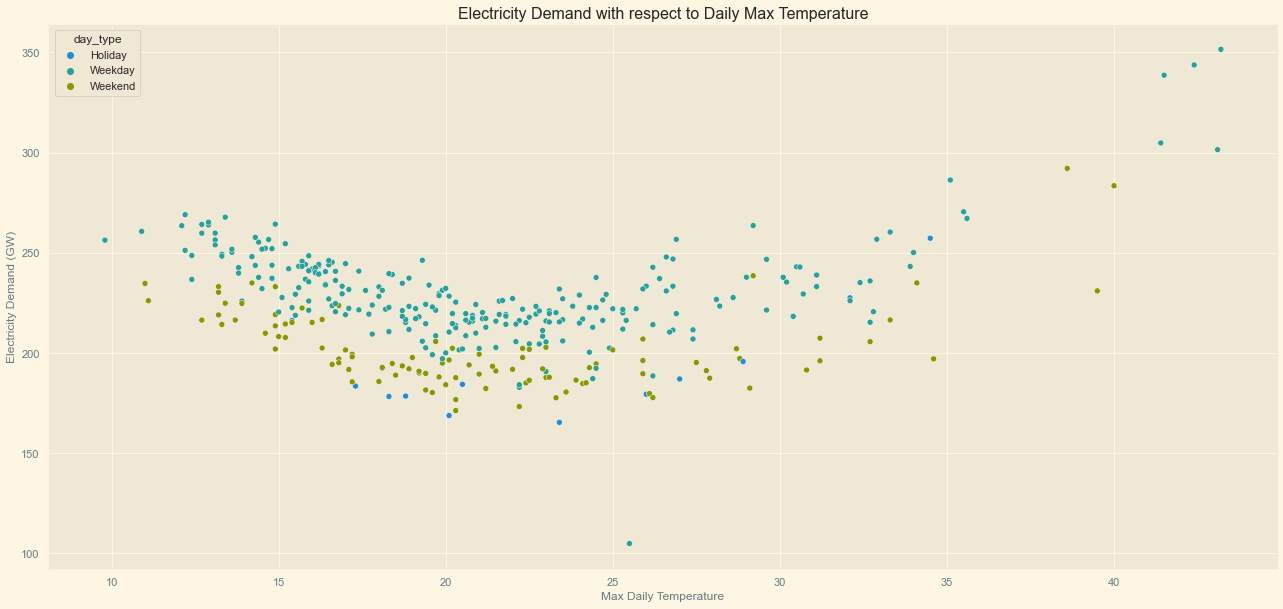

In [362]:
sns.set(rc={'figure.figsize': (22, 10)})
plt.style.use('Solarize_Light2')

ax = sns.scatterplot(
    x='Temperature',
    y='Demand',
    hue='day_type',
    data=victoria_electricity_2014
)

# set title and labels
ax.set_title("Electricity Demand with respect to Daily Max Temperature")
ax.set_ylabel("Electricity Demand (GW)")
ax.set_xlabel("Max Daily Temperature")

The plots highlight the need for both a non-linear and a dynamic model.



In [ ]:
# just rename for now
y_train, y_test, X_train, X_test = temporal_train_test_split(
    victoria_electricity_2014.Demand,
    victoria_electricity_2014[['Temperature', 'day_type']]
)

# create forecast horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

numerical_transformer = Pipeline([
    ("scaler", StandardScaler()),
    ('polynomization', PolynomialFeatures(include_bias=False))
])

# fit the predictors in a separate transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(sparse=False), ['day_type']),
        ("numerical", numerical_transformer, ['Temperature'])
    ]
)

# pipeline with the preprocessing and attaching of names and index afterwards
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lambda', FunctionTransformer(func=lambda X: pd.DataFrame(
        X,
        columns=preprocessor.get_feature_names_out(),
        # this has to be dynamic according to what is given, if we apply the transformation to another
        # dataframe it will not work
        index=X_train.index
    ), validate=False))
])

# Transform the data in a separate transformer
# For now, I couldn't do it using a ForecastingPipeline
X_train_transformed = pipeline.fit_transform(X=X_train, y=y_train)

forecaster = AutoARIMA()
forecaster.fit(y_train, X=X_train_transformed)
# auto_arima_forecaster.fit(y=y_train, X=X_train)

In [394]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lambda', FunctionTransformer(func=lambda X: pd.DataFrame(
        X,
        columns=preprocessor.get_feature_names_out(),
        index=X_test.index
    ), validate=False))
])

X_test_transformed = pipeline.fit_transform(X=X_test, y=y_test)
X_test_transformed

,categorical__day_type_Holiday,categorical__day_type_Weekday,categorical__day_type_Weekend,numerical__Temperature,numerical__Temperature^2
2014-10-01,0.0,1.0,0.0,-1.613330,2.602833
2014-10-02,0.0,1.0,0.0,-1.294590,1.675964
2014-10-03,0.0,1.0,0.0,-0.529616,0.280493
2014-10-04,0.0,0.0,1.0,0.575348,0.331025
2014-10-05,0.0,0.0,1.0,-0.912103,0.831932
...,...,...,...,...,...
2014-12-27,0.0,0.0,1.0,-0.274624,0.075418
2014-12-28,0.0,0.0,1.0,1.637813,2.682431
2014-12-29,0.0,1.0,0.0,0.575348,0.331025
2014-12-30,0.0,1.0,0.0,0.192860,0.037195


In [342]:
# auto_arima_forecaster = ForecastingPipeline(
#     steps=[
#         # ("columns", preprocessor),
#         # ("attach_index", FunctionTransformer(func=lambda X: pd.DataFrame(X, index=X_train.index))),
#         # ("polynomial", TabularToSeriesAdaptor(PolynomialFeatures())),
#         # ('a', preprocessor),
#         # ("boxcox", TabularToSeriesAdaptor(PowerTransformer(method="box-cox"))),
#         ('pipe', pipeline),
#         ('tabularize', Tabularizer()),
#         ("forecaster", AutoARIMA(suppress_warnings=True))
#     ]
# )

In [364]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  273
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1003.796
Date:                Wed, 23 Mar 2022   AIC                           2029.592
Time:                        01:11:49   BIC                           2069.296
Sample:                    01-01-2014   HQIC                          2045.530
                         - 09-30-2014                                         
Covariance Type:                  opg                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
intercept                         0.0629      0.087      0.727      0.467      -0.107       0.232
categorical__day_type_Holiday   194.8490      2.138     91.152      0.000     190.659     199.039
categorical__day_type_Weekday   216.3411      1.375    157.317      0.000     213.646     219.036
categorical__day_type_Weekend   190.7369      1.343    142.070      0.000     188.106     193.368
numerical__Temperature           -2.4941      1.642     -1.519      0.129      -5.712       0.723
numerical__Temperature^2          8.9482      0.480     18.659      0.000       8.008       9.888
ar.L1                             1.3726      0.183      7.511      0.000       1.014       1.731
ar.L2                            -0.3858      0.172     -2.239      0.025      -0.724      -0.048
ma.L1                            -0.7583      0.190     -4.000      0.000      -1.130      -0.387
ma.L2                            -0.0978      0.117     -0.833      0.405      -0.328       0.132
sigma2                           91.3690      6.270     14.573      0.000      79.081     103.657
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               109.77
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+17. Standard errors may be unstable.
"""

In [395]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh, X=X_test_transformed)

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:499: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:509: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/sktime/utils/datetime.py:67: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/sktime/utils/datetime.py:68: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/sk

Text(0.5, 1.0, 'Prediction of Victoria Electricity')

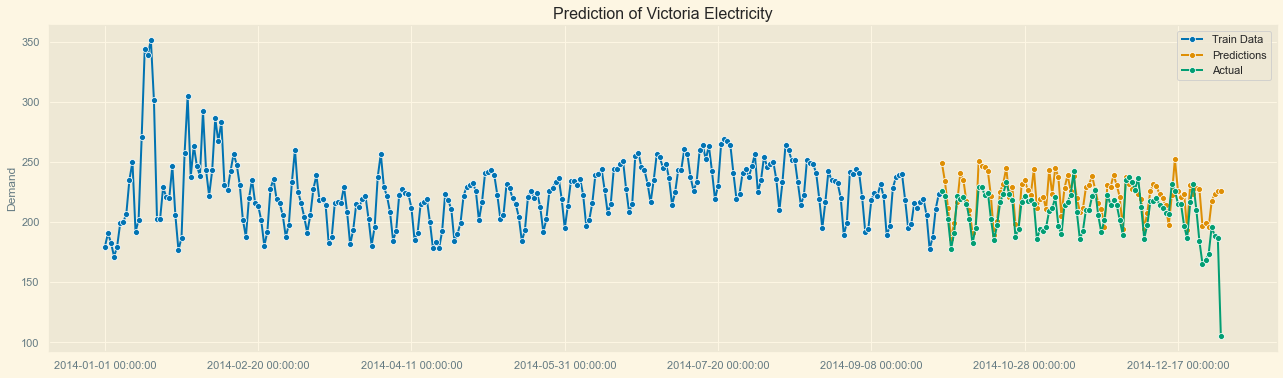

In [396]:
fig, ax = plot_series(
    y_train, y_pred, y_test,
    labels=["Train Data", "Predictions", "Actual"]
)

fig.set_figwidth(22)
fig.set_figheight(6)
ax.set_title("Prediction of Victoria Electricity")
# fh

### Stochastic and deterministic trends

There are two different ways of modelling a linear trend. A deterministic trend is obtained using the regression model
$$
y_t = β_0 + β_1 t + η_t
$$ 
where   $η_t$   is an ARMA process.

A stochastic trend is obtained using the model 
$$
y_t = β_0 + β_1 t + η_t
$$
 ,   where   $η_t$   is an ARIMA process with   d = 1  .

 ### Example: Air transport passengers Australia


In [454]:
aus_airpassengers_df.Passengers

0      7.318700
1      7.326600
2      7.795600
3      9.384600
4     10.664700
5     11.055100
6     10.864300
7     11.306500
8     12.122300
9     13.022500
10    13.648800
11    13.219500
12    13.187900
13    12.601500
14    13.236800
15    14.412100
16    15.497300
17    16.880200
18    18.816300
19    15.114300
20    17.553400
21    21.860100
22    23.886600
23    26.929300
24    26.888500
25    28.831400
26    30.075100
27    30.953500
28    30.185700
29    31.579700
30    32.577569
31    33.477398
32    39.021581
33    41.386432
34    41.596552
35    44.657324
36    46.951775
37    48.728837
38    51.488427
39    50.026967
40    60.640913
41    63.360310
42    66.355274
43    68.197955
44    68.123238
45    69.779345
46    72.597701
Name: Passengers, dtype: float64

Text(0, 0.5, 'Passengers (millions)')

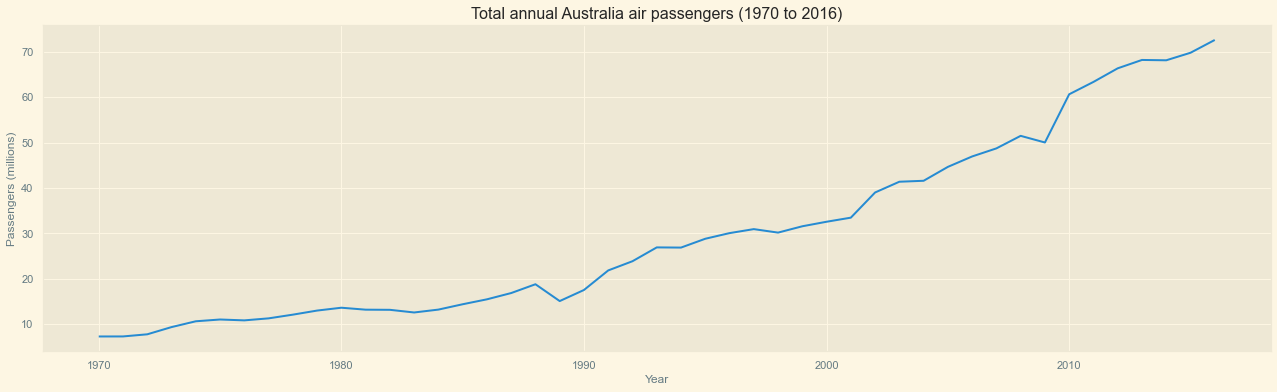

In [474]:
aus_airpassengers_df = load_data('aus_airpassengers').set_index('Year')

min_year = aus_airpassengers_df.index.min()
max_year = aus_airpassengers_df.index.max()

# date_index = pd.date_range(
#     start=pd.datetime(min_year, 1, 1),
#     end=pd.datetime(max_year, 1, 1),
#     freq=pd.DateOffset(years=1)
# )

passengers_ts = aus_airpassengers_df.Passengers
passengers_ts

ax = passengers_ts.plot(figsize=(22, 6))
ax.set_title("Total annual Australia air passengers (1970 to 2016)")
ax.set_ylabel("Passengers (millions)")

##### Forecasts with a Deterministic Trend

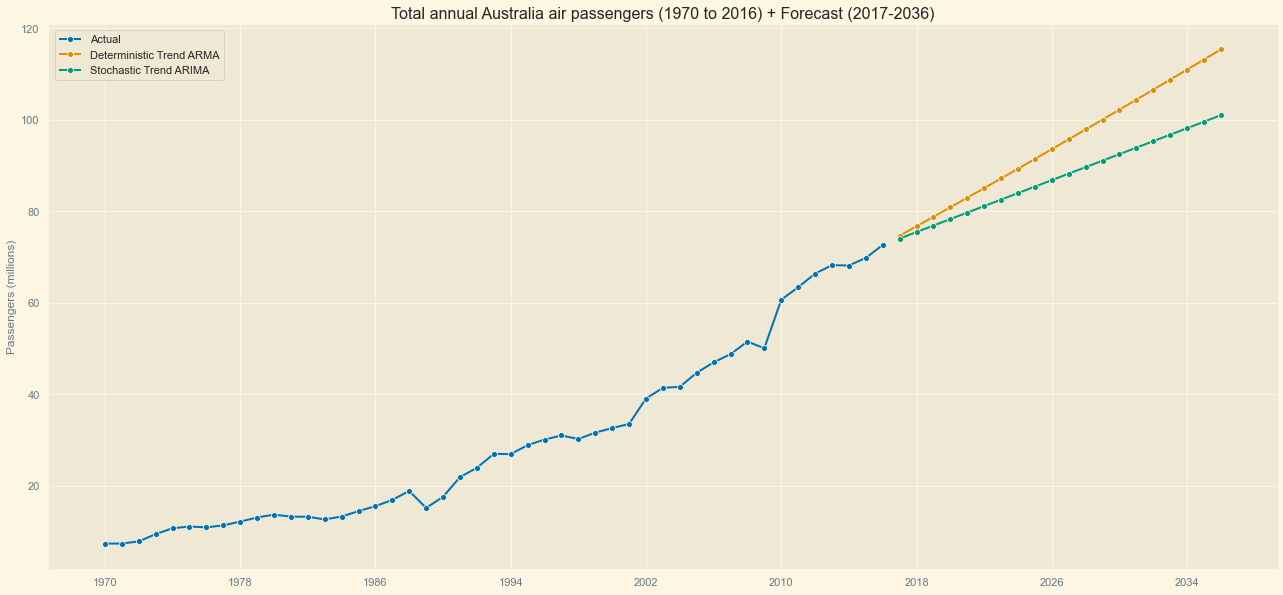

In [582]:
ALPHA = 0.60
# define deterministic and stochastic trend models
dt_forecaster = ARIMA(order=(1, 0, 0), supress_warnings=True, trend='ct', with_intercept=True)
st_forecaster = ARIMA(order=(0, 1, 0), supress_warnings=True, trend='c', with_intercept=True)

# train the models
dt_forecaster.fit(passengers_ts)
st_forecaster.fit(passengers_ts)

forecast_index = np.arange(20)+passengers_ts.shape[0]

dt_y_pred = dt_forecaster.predict(np.arange(20) + 1)
st_y_pred = st_forecaster.predict(np.arange(20) + 1)

ax = plt.subplot()
plot_series(passengers_ts, dt_y_pred, st_y_pred, labels=["Actual", "Deterministic Trend ARMA", "Stochastic Trend ARIMA"], ax=ax)

# ci = dt_forecaster.predict_interval(coverage=ALPHA)['Coverage'][ALPHA]
# ax.fill_between(forecast_index, ci.lower, ci.upper, color='#ee9b00', alpha=0.3)

ax.set_title("Total annual Australia air passengers (1970 to 2016) + Forecast (2017-2036)")
ax.set_ylabel("Passengers (millions)")

fig.set_figheight(6)
fig.set_figwidth(22)

We will fit both a deterministic and a stochastic trend model to these data.



##### Deterministic Trend Summary

In [579]:
dt_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -97.131
Date:                Wed, 23 Mar 2022   AIC                            202.262
Time:                        17:18:27   BIC                            209.663
Sample:                             0   HQIC                           205.047
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1830      1.027      0.178      0.859      -1.830       2.196
drift          0.1199      0.117      1.028      0.304      -0.109       0.349
ar.L1          0.9480      0.077     12.367      0.000       0.798       1.098
sigma2         3.4787      0.470      7.409      0.000       2.558       4.399
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):               118.62
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):              10.85   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Stochastic Trend Summary

In [572]:
st_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -98.156
Date:                Wed, 23 Mar 2022   AIC                            200.311
Time:                        17:14:29   BIC                            203.969
Sample:                             0   HQIC                           201.681
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4191      0.367      3.866      0.000       0.700       2.139
sigma2         4.1777      0.489      8.552      0.000       3.220       5.135
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               129.55
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               6.63   Skew:                             1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Dynamic harmonic regression

- When there are long seasonal periods, a dynamic regression with Fourier terms is often better than other models.

- Seasonal versions of ARIMA and ETS models are designed for shorter periods such as 12 for monthly data or 4 for quarterly data.

- The ETS() model restricts seasonality to be a maximum period of 24 to allow hourly data but not data with a larger seasonal period. The problem is that there are  m−1  parameters to be estimated for the initial seasonal states where  m  is the seasonal period. So for large  m , the estimation becomes almost impossible.

So for such time series, we prefer a harmonic regression approach where the seasonal pattern is modelled using Fourier terms with short-term time series dynamics handled by an ARMA error.

The advantages of this approach are:

- it allows any length seasonality;
- for data with more than one seasonal period, Fourier terms of different frequencies can be included;
- the smoothness of the seasonal pattern can be controlled by K, the number of Fourier sin and cos pairs – the seasonal pattern is smoother for smaller values of K;
- the short-term dynamics are easily handled with a simple ARMA error.

The advantages

- The only real disadvantage (compared to a seasonal ARIMA model) is that the seasonality is assumed to be fixed — the seasonal pattern is not allowed to change over time. But in practice, seasonality is usually remarkably constant so this is not a big disadvantage except for long time series.

### Example: Australian eating out expenditure

In this example we demonstrate combining Fourier terms for capturing seasonality with ARIMA errors capturing other dynamics in the data. For simplicity, we will use an example with monthly data. The same modelling approach using weekly data is discussed in Section



In [655]:
N = turnover_ts.index.shape[0]

start = turnover_ts.index.min()
end = turnover_ts.index.max()

range_index = pd.date_range(
    start=start,
    # end=end,
    periods=N,
    freq='M',
    normalize=True
)

range_index.min()

Timestamp('2004-01-31 00:00:00', freq='M')

<AxesSubplot:>

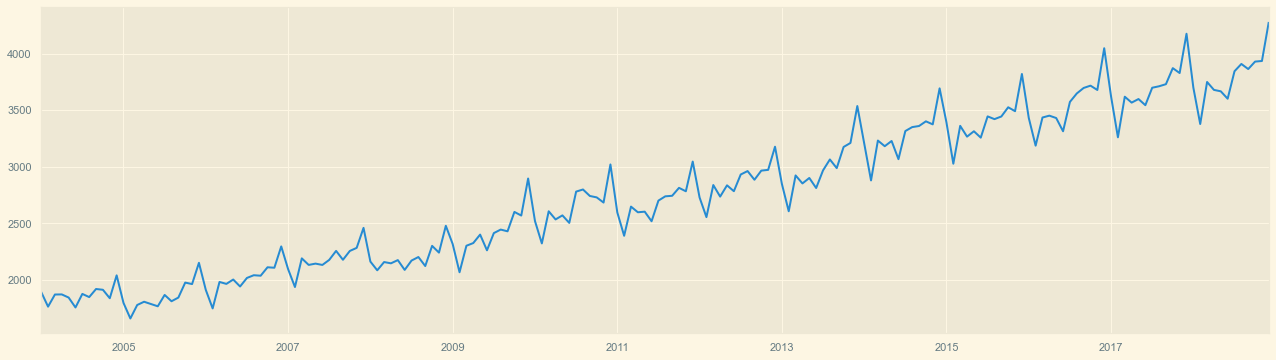

In [656]:

aus_retail_df = load_data("aus_retail").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year, Month=lambda df: df.Date.dt.month
)

is_cafe = aus_retail_df.Industry == "Cafes, restaurants and takeaway food services"
is_between_2004_and_2018 = aus_retail_df.Date.dt.year.between(2004, 2018)
aus_cafe_df = aus_retail_df[is_cafe & is_between_2004_and_2018]

# sumamrise by date
turnover_ts = aus_cafe_df.groupby('Date').sum().Turnover


N = turnover_ts.index.shape[0]

start = turnover_ts.index.min()
end = turnover_ts.index.max()

range_index = pd.date_range(
    start=start,
    # end=end,
    periods=N,
    freq='M'
)

turnover_ts.index = range_index

turnover_ts.plot(figsize=(22, 6))


(180,)

In [641]:
turnover_ts.index.shape

(180,)

Text(0.5, 1.0, 'Actual and predicted using unobserved components')

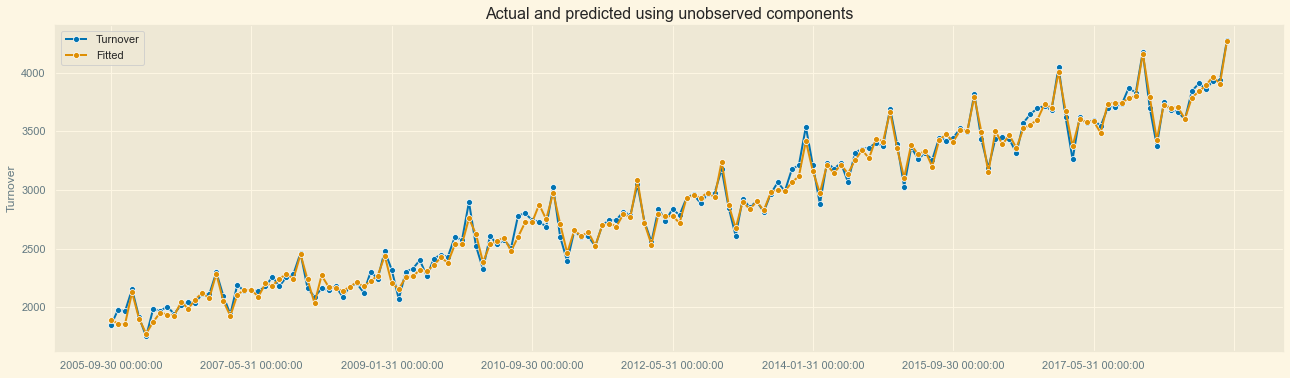

In [669]:
from sktime.forecasting.structural import UnobservedComponents

forecaster = UnobservedComponents(
    level="local linear trend", freq_seasonal=[{"period": 12, "harmonics": 20}]
)
fh = np.arange(1, 37) + 1

forecaster.fit(turnover_ts) 
fig, ax = plot_series(
    turnover_ts[20:], forecaster._fitted_forecaster.fittedvalues[20:],
    labels=["Turnover", "Fitted"]
)

fig.set_figwidth(22)
fig.set_figheight(6)

ax.set_title("Actual and predicted using unobserved components")
# getting predictions doesn't work
# y_pred = forecaster.predict(fh)
# forecaster.summary()
# y_pred
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# mean_absolute_percentage_error(y_pred, y_test)

In [670]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                               Turnover   No. Observations:                  180
Model:                             local linear trend   Log Likelihood                -752.223
                   + stochastic freq_seasonal(12(20))   AIC                           1512.447
Date:                                Thu, 24 Mar 2022   BIC                           1524.156
Time:                                        12:25:41   HQIC                          1517.205
Sample:                                    01-31-2004                                         
                                         - 12-31-2018                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.irregular              604.2838    219.622      2.751      0.006     173.833    1034.735
sigma2.level                  815.9197    239.688      3.404      0.001     346.139    1285.700
sigma2.trend                    0.0159      0.390      0.041      0.967      -0.748       0.780
sigma2.freq_seasonal_12(20)     1.6655      0.701      2.376      0.018       0.292       3.040
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.61   Prob(JB):                         0.93
Heteroskedasticity (H):               0.49   Skew:                             0.07
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 12.3 Vector autoregressions

- One limitation of the models that we have considered so far is that they impose a unidirectional relationship — the forecast variable is influenced by the predictor variables, but not vice versa.
- However, there are many cases where the reverse should also be allowed for — where all variables affect each other

- Such feedback relationships are allowed for in the vector autoregressive (VAR) framework. In this framework, all variables are treated symmetrically. They are all modelled as if they all influence each other equally. In more formal terminology, all variables are now treated as “endogenous”. To signify this, we now change the notation and write all variables as  
$y_s:  y_{1,t}$  denotes the  t-th observation of variable  $y_1 , y_{2,t}$  denotes the  t th observation of variable  $y_2$ , and so on.

- A VAR model is a generalisation of the univariate autoregressive model for forecasting a vector of time 
series

We write a 2-dimensional VAR(1) model as
$$
y_{1,t}=c_1+ϕ_{11,1}y_{1,t−1}+ϕ_{12,1}y_{2,t−1}+ε_{1t}\\
y_{2,t}=c_2+ϕ_{21,1}y_{1,t−1}+ϕ_{22,1}y_{2,t−1}+ε_{2,t}
$$
VARs are useful in several contexts:

1. forecasting a collection of related variables where no explicit interpretation is required;
2. testing whether one variable is useful in forecasting another (the basis of Granger causality tests);
3. impulse response analysis, where the response of one variable to a sudden but temporary change in another variable is analysed;
4. forecast error variance decomposition, where the proportion of the forecast variance of each variable is attributed to the effects of the other variables.

### Example: A VAR model for forecasting US consumption

In [683]:
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.var import VAR
from sktime.forecasting.fbprophet import Prophet


var_model = VAR(maxlags=1)

var_pipeline = TransformedTargetForecaster(steps=[
  ('differencer', Differencer()),
  ('forecaster', var_model)
])

In [692]:
X = us_change_df[['Consumption', 'Income']]

var_pipeline.fit(X)
var_model.

#> # A mable: 1 x 2
#>               aicc              bic
#>            <model>          <model>
#> 1 <VAR(5) w/ mean> <VAR(1) w/ mean>

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


TypeError: y must be a supported Series mtype